# 학습 목표
- 데이터의 편향성에 대한 문제의식을 갖는다.
- 임베딩 모델의 편향성을 체크하는 방법 중 하나인 Word Embedding Association Test (WEAT)를 알아본다.
- WEAT 수식의 의미를 이해하고 이를 구현해본다.
- pre-train된 모델을 불러와서 WEAT score를 구해본다

# 목차
- 워드 임베딩의 편향성
- WEAT를 통한 편향성 측정
- WEAT 구현하기
- 사전학습된 Word Embedding에 WEAT 적용
- 직접 만드는 Word Embedding에 WEAT 적용(1)
- 직접 만드는 Word Embedding에 WEAT 적용(2)
- 프로젝트 : 모든 장르 간 편향성 측정해 보기

# (1) 워드 임베딩 속 편향성

예시   
젠더 중립적인 단어임에도 불구하고 Programmer, Doctor, Engineer 등의 단어는 남성대명사 He에 가깝게,       
Homemaker, Nurse, Hairdresser 등의 단어는 여성대명사 She에 가깝게 위치하는 것    

워드 임베딩 벡터들 간에는 의미적인 유사도 거리를 정량적으로 측정할 수 있음    
편향성도 정량적으로 측정할 수 있음    
`Word Embedding Association Test (WEAT)`는 임베딩 모델의 편향을 측정하는 방식 중 하나    

WEAT는 Male과 Female, Science와 Art라는 개념을 가장 잘 대표하는 단어들을 여러 개 골라 단어 셋(set)을 만듦   
이러한 단어 셋을 WEAT에서는 각각 target과 attribute라 함

Science를 대표하는 target 단어 셋 X와 Art를 대표하는 target 단어 셋 Y가 있다고 하면 X-Y 셋을 통한 개념축 하나   
Male을 대표하는 attribute 단어 셋 A와 Female을 대표하는 attribute 단어 셋 B가 있다면 A-B 셋을 통한 개념축 하나    
편향성이 없다면, X에 속한 단어들은 A에 속한 단어들과의 거리나 B에 속한 단어들과의 거리가 별 차이가 없어야 함    
반대의 경우라면 뚜렷하게 차이   


# (2) WEAT 구현하기

In [1]:
# 패키지 임포트
import numpy as np
from numpy import dot
from numpy.linalg import norm

In [2]:
# 타겟 단어셋 A,B 와 attribute 단어셋 X,Y 정의
target_A = {
    '장미': [4.1, 1.2, -2.4, 0.5, 4.1],
    '튤립': [3.1, 0.5, 3.6, 1.7, 5.8],
    '백합': [2.9, -1.3, 0.4, 1.1, 3.7],
    '데이지': [5.4, 2.5, 4.6, -1.0, 3.6]
}
target_B = {
    '거미': [-1.5, 0.2, -0.6, -4.6, -5.3],
    '모기': [0.4, 0.7, -1.9, -4.5, -2.9],
    '파리': [0.9, 1.4, -2.3, -3.9, -4.7],
    '메뚜기': [0.7, 0.9, -0.4, -4.1, -3.9]
}
attribute_X = {
    '사랑':[2.8,  4.2, 4.3,  0.3, 5.0],
    '행복':[3.8,  3. , -1.2,  4.4, 4.9],
    '웃음':[3.7, -0.3,  1.2, -2.5, 3.9]
}
attribute_Y = {
    '재난': [-0.2, -2.8, -4.7, -4.3, -4.7],
    '고통': [-4.5, -2.1,  -3.8, -3.6, -3.1],
    '증오': [-3.6, -3.3, -3.5,  -3.7, -4.4]
}

In [3]:
# numpy array 형태로 변환

A = np.array([v for v in target_A.values()])
B = np.array([v for v in target_B.values()])

X = np.array([v for v in attribute_X.values()])
Y = np.array([v for v in attribute_Y.values()])

In [4]:
# 코사인 유사도 함수
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

# 코사인 유사도 비교 함수
def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B#, c_a, c_b

print(s(attribute_X['사랑'], A, B))

0.5901751654626237


WEAT score값이 양수이므로, attribute_X에 있는 '사랑'이라는 단어는 target_B(곤충)보다 target_A(꽃)와 더 가깝다는 것을 의미    
A값에는 양수가, B값에는 음수가 많이 분포하기 때문    

In [5]:
# attribute_Y에 있는 '재난'과의 관계
print(s(attribute_Y['재난'], A, B))

-0.6691842929755343


In [6]:
# attribute_X와 target_A, target_B 사의의 평균값은?
print(s(X, A, B))
print(round(np.mean(s(X, A, B)), 3))

# X는 대체로 A에 가깝다

[0.37181942 0.41632807 0.21117431]
0.333


In [7]:
# attribute_Y와 target_A, target_B 사의의 평균값은? 
print(s(Y, A, B))
print(round(np.mean(s(Y, A, B)), 3))

# Y는 대체로 B에 가깝다

[-0.39609272 -0.37389852 -0.41242037]
-0.394


In [8]:
# WEAT 구현
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

In [9]:
# WEAT (편향성 계산)
print(round(weat_score(X, Y, A, B), 3))

# 0에서 크게 떨어져 있으며, 편향성이 존재한다고 판단

1.97


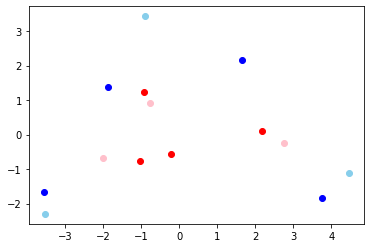

In [10]:
# 주성분 분석을 통한 시각화
# 5차원 벡터를 2차원으로 줄이며 시각화

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc_A = pca.fit_transform(A)
pc_B = pca.fit_transform(B)
pc_X = pca.fit_transform(X)
pc_Y = pca.fit_transform(Y)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(pc_A[:,0],pc_A[:,1], c='blue', label='A')
ax.scatter(pc_B[:,0],pc_B[:,1], c='red', label='B')
ax.scatter(pc_X[:,0],pc_X[:,1], c='skyblue', label='X')
ax.scatter(pc_Y[:,0],pc_Y[:,1], c='pink', label='Y')

# 파란색 점(A)과 하늘색 점(X)이 가깝고, 빨간색 점(B)과 분홍색 점(Y)이 가깝게 표현된 것을 확인

In [11]:
# pretrain된 임베딩 모델을 불러오기
# target과 attribute가 이미 학습된 모델을 불러와 WEAT으로 측정하기 위함!!

import os

data_dir = '~/aiffel/weat' 
model_dir = os.path.join(data_dir, 'GoogleNews-vectors-negative300.bin') # 미리 학습한 모델 path

from gensim.models import KeyedVectors

# 50만개의 단어만 활용합니다. 메모리가 충분하다면 limit 파라미터값을 생략하여 300만개를 모두 활용할 수 있습니다. 
w2v = KeyedVectors.load_word2vec_format(model_dir, binary=True, limit=500000)

In [12]:
w2v

In [13]:
print(len(w2v.vocab))   # Gensim 3.X 버전까지는 w2v.vocab을 직접 접근할 수 있습니다. 
# print(len(w2v.index_to_key))   # Gensim 4.0부터는 index_to_key를 활용해 vocab size를 알 수 있습니다. 
print(len(w2v['I']))                    # 혹은 단어를 key로 직접 vector를 얻을 수 있습니다. 
print(w2v.vectors.shape)


# w2v에는 limit으로 지정한 갯수(디폴트는 3,000,000개)의 단어가 있고, 각 단어는 300차원을 갖는다
# 즉 w2v내에 50만개의 단어가 있고, 각 단어는 300차원

500000
300
(500000, 300)


In [14]:
# happy와 가장 유사한 단어 출력
w2v.most_similar(positive=['happy'])

[('glad', 0.7408890724182129),
 ('pleased', 0.6632170677185059),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286794662476),
 ('thrilled', 0.6514049768447876),
 ('satisfied', 0.6437948942184448),
 ('proud', 0.636042058467865),
 ('delighted', 0.6272379159927368),
 ('disappointed', 0.6269949674606323),
 ('excited', 0.6247665882110596)]

In [15]:
# family와 유사한 단어 출력
w2v.most_similar(positive=['family'])

# 오타로 추정되는 단어도 확인

[('relatives', 0.6662652492523193),
 ('familiy', 0.6517066955566406),
 ('families', 0.6252894401550293),
 ('siblings', 0.6140849590301514),
 ('friends', 0.6128394603729248),
 ('mother', 0.6065611839294434),
 ('aunt', 0.5811319947242737),
 ('grandparents', 0.576207160949707),
 ('father', 0.5717043876647949),
 ('Family', 0.5672314763069153)]

In [16]:
# school과 유사한 단어 출력
w2v.most_similar(positive=['school'])

[('elementary', 0.7868632674217224),
 ('schools', 0.7411909103393555),
 ('elementary_schools', 0.6597153544425964),
 ('kindergarten', 0.6529810428619385),
 ('eighth_grade', 0.6488089561462402),
 ('School', 0.6477997303009033),
 ('teacher', 0.63824063539505),
 ('students', 0.6301523447036743),
 ('classroom', 0.6281620860099792),
 ('Schools', 0.6172096133232117)]

In [17]:
# WEAT을 통한 해당 모델의 편향성 측정
target_A = ['science', 'technology', 'physics', 'chemistry', 'Einstein', 'NASA', 'experiment', 'astronomy']
target_B = ['poetry', 'art', 'Shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']
attribute_X = ['brother', 'father', 'uncle', 'grandfather', 'son', 'he', 'his', 'him']
attribute_Y = ['sister', 'mother', 'aunt', 'grandmother', 'daughter', 'she', 'hers', 'her']

A = np.array([w2v[word] for word in target_A])
B = np.array([w2v[word] for word in target_B])
X = np.array([w2v[word] for word in attribute_X])
Y = np.array([w2v[word] for word in attribute_Y])

weat_score(X, Y, A, B)

# 강한 편향성이 존재
# 과학, 기술 등은 남성을 의미하는 단어와 가깝고 
# 시, 예술 등은 여성을 의미하는 단어와 가깝다.

1.4821917

In [18]:
# 다른 편향성을 갖는 집단을 전달해 편향성 측정
target_A = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_B = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_X = ['junk', 'canned', 'convenience', 'frozen', 'fast']
attribute_Y = ['health', 'beneficial', 'good', 'nourishing', 'nutritious']

A = np.array([w2v[word] for word in target_A])
B = np.array([w2v[word] for word in target_B])
X = np.array([w2v[word] for word in attribute_X])
Y = np.array([w2v[word] for word in attribute_Y])

weat_score(X, Y, A, B)

# 0보다 크며 편향성 존재

1.6929383

In [19]:
# WEAT 성능 자체를 검사하기 위해 특정 속성을 나타내는 단어와 연관없는 단어를 짝지음
target_A = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_B = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_X = ['book', 'essay', 'dictionary', 'magazine', 'novel']
attribute_Y = ['news', 'report', 'statement', 'broadcast', 'word']

A = np.array([w2v[word] for word in target_A])
B = np.array([w2v[word] for word in target_B])
X = np.array([w2v[word] for word in attribute_X])
Y = np.array([w2v[word] for word in attribute_Y])

weat_score(X, Y, A, B)

# 0에 가까우며 편향성이 존재하지 않는다.

-0.082050726

In [20]:
#메모리를 다시 비워줍시다.
del w2v
print("삭제 완료")

삭제 완료


# (3) 직접 만드는 Word Embedding에 WEAT 적용

In [ ]:
### 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

In [22]:
import os

# 2001년부터 2019년 8월까지 제작된 한국 영화들의 시놉시스
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='') # 줄마다 읽어오기

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

In [23]:
#  synopsis.txt 파일을 읽어 품사가 명사인 경우만 남겨 tokenized라는 변수명으로 저장
# 약 15분정도 걸립니다.
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True) # 단어의 원형 형태로 복구
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # 명사 형태 출력 / "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

In [25]:
# 토크나이즈된 명사 개수 확인
print(len(tokenized))

71156


In [41]:
print(tokenized[0])

['사운드', '엔지니어', '상우', '유지태', '분', '치매', '할머니', '백성희', '분']


### 2. 추출된 결과로 embedding model 만들기

In [26]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
# model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
# model.wv.most_similar(positive=['영화'])

# Gensim 3.X 에서는 아래와 같이 생성합니다. 
model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
model.most_similar(positive=['영화'])

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':


[('작품', 0.9105345010757446),
 ('다큐멘터리', 0.8701580762863159),
 ('드라마', 0.8313028812408447),
 ('영화로', 0.8287745714187622),
 ('코미디', 0.8238655924797058),
 ('주제', 0.810356855392456),
 ('편의', 0.8094469308853149),
 ('형식', 0.8073041439056396),
 ('소재', 0.7873591780662537),
 ('설정', 0.7803307771682739)]

In [27]:
# 사랑 과 유사한 단어 출력
model.wv.most_similar(positive=['사랑'])

[('아르튬', 0.7418205738067627),
 ('시빌라', 0.7322015762329102),
 ('애정', 0.7197073698043823),
 ('이별', 0.7150620222091675),
 ('첫사랑', 0.7128638029098511),
 ('행복', 0.7125250101089478),
 ('연애', 0.7109021544456482),
 ('만남', 0.7083183526992798),
 ('진심', 0.7018920183181763),
 ('고백', 0.7018511295318604)]

In [28]:
# 연극 과 유사한 단어 출력
model.wv.most_similar(positive=['연극'])

[('영화감독', 0.896085262298584),
 ('영감', 0.8885893225669861),
 ('예술가', 0.8861727118492126),
 ('오페라', 0.8820048570632935),
 ('무용', 0.8761301040649414),
 ('대본', 0.8759975433349609),
 ('배우', 0.8741676211357117),
 ('감성', 0.8739222884178162),
 ('아티스트', 0.872863233089447),
 ('헤드윅', 0.8712911605834961)]

# (4) 직접 만드는 Word Embedding에 WEAT 적용(2)

### 3. TF-IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기

WEAT score를 구할 때 단어 셋을 만들어주어야 함 (ex. targets_X, targets_Y, attribute_A, attribute_B)   
때문에 두 축을 어떤 기준으로 잡고, 해당 축의 어떤 항목을 사용할지 정해야 함   
여기서 영화 장르, 영화 구분 정보를 이용   

영화 구분
- synopsis_art.txt : 예술영화
- synopsis_gen.txt : 일반영화(상업영화)
- 그 외 독립영화 등으로 분류됩니다.

장르 구분
- synopsis_SF.txt: SF
- synopsis_가족.txt: 가족
- synopsis_공연.txt: 공연
- synopsis_공포(호러).txt: 공포(호러)
- synopsis_기타.txt: 기타
- synopsis_다큐멘터리.txt: 다큐멘터리
- synopsis_드라마.txt: 드라마
- synopsis_멜로로맨스.txt: 멜로로맨스
- synopsis_뮤지컬.txt: 뮤지컬
- synopsis_미스터리.txt: 미스터리
- synopsis_범죄.txt: 범죄
- synopsis_사극.txt: 사극
- synopsis_서부극(웨스턴).txt: 서부극(웨스턴)
- synopsis_성인물(에로).txt: 성인물(에로)
- synopsis_스릴러.txt: 스릴러
- synopsis_애니메이션.txt: 애니메이션
- synopsis_액션.txt: 액션
- synopsis_어드벤처.txt: 어드벤처
- synopsis_전쟁.txt: 전쟁
- synopsis_코미디.txt: 코미디
- synopsis_판타지.txt: 판타지

In [29]:
# 예술영화와 일반영화(상업영화)라는 영화구분을 target으로 삼고, 
# 드라마 장르와 액션 장르라는 장르구분을 attribute로 삼아 WEAT score를 계산

# 이것의 의미는, 드라마 장르에는 예술영화적 성격이 강하고, 
# 액션 장르에는 일반(상업)영화적 성격이 강할 것이라는 편향성이 
# 워드 임베딩 상에 얼마나 나타나고 있는지를 측정해 보겠다는 것

import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

# 텍스트를 읽어 명사를 저장하는 함수
def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [30]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다. 

art = read_token(art_txt) # 예술영화 시놉시스
gen = read_token(gen_txt) # 상업영화 시놉시스

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


WEAT 계산을 위해서는 총 4개의 단어 셋 X, Y, A, B가 필요   
예를 들어, 예술영화라는 개념을 가장 잘 대표하는 단어들을 art_txt를 처리해서 만든 art라는 단어 리스트에서부터 골라내야 하는 것   
그렇다면 임의로 설정하는 것보다는 정확한 방법으로 각 주제를 대표하는 단어를 추출할 필요가 있음   
어떤 개념을 나타내는 단어를 선정하는 방법으로 어떤 것이 적당할까?    
예컨대 예술영화를 잘 대표하는 단어란,     
예술영화 시놉시스에는 자주 나타나지만 그 외 다른 구분의 영화(예를 들어 일반영화) 시놉시스에는 자주 나타나지 않는 것을 고르는 것이 적당    

이런 것과 비슷한 개념의 단어 분석 방식 중 TF-IDF 방식 존재    
코퍼스에서 자주 나타나는(TF가 높은) 단어이지만, 다른 코퍼스에까지 두루 걸쳐 나오지는 않는(IDF가 높은) 단어를 선정    
때문에 단어 셋 구성을 위해 TF-IDF방식을 사용   

In [31]:
# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [32]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


In [33]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 spart matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 spart matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

In [34]:
# 상위 100개의 단어들 중 중복되는 단어를 제외하고 상위 n(=15)개의 단어를 추출
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [35]:
# 추출된 단어 파악
print("[예술영화]")
print(target_art)
print()
print("[일반영화]")
print(target_gen)

[예술영화]
['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']

[일반영화]
['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


In [36]:
# 장르별 리스트 설정
genre_txt = ['synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_action.txt', 'synopsis_comedy.txt', 'synopsis_war.txt', 'synopsis_horror.txt']
genre_name = ['드라마', '멜로로맨스', '액션', '코미디', '전쟁', '공포(호러)']

In [37]:
# 장르별 명사 추출
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.


In [38]:
# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(6, 33151)


In [39]:
# 각 장르를 대표하는 단어들 추출
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

드라마: 자신, 영화제, 그녀, 사람, 사랑, 위해, 영화, 시작, 국제, 남자, 친구, 이야기, 여자, 아버지, 엄마, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남자, 남편, 여자, 사람, 친구, 위해, 마음, 섹스, 결혼, 서로, 아내, 
액션: 위해, 자신, 시작, 조직, 사건, 사람, 그녀, 경찰, 전쟁, 친구, 모든, 목숨, 사실, 세계, 가족, 
코미디: 그녀, 자신, 시작, 위해, 사랑, 사람, 친구, 영화, 남자, 여자, 영화제, 가족, 과연, 마을, 사건, 
전쟁: 전쟁, 위해, 전투, 시작, 작전, 독일군, 부대, 독일, 윈터스, 자신, 사람, 공격, 임무, 연합군, 병사, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 남자, 가족, 영화, 하나, 


### 4. embedding model과 단어 셋으로 WEAT score 구해보기

WEAT_score 계산       
traget_A는 art // target_B는 gen // attribute_X는 '드라마' // attribute_Y는 '액션'       

target_A와 target_B는 고정하고, attribute_X, attribute_Y를 바꿔가면서 WEAT 계산        
구한 결과를 21x21 매트릭스 형태로 표현     

In [42]:
# 매트릭스 선언
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [43]:
# 타겟 데이터셋 선언
A = np.array([model.wv[word] for word in target_art])
B = np.array([model.wv[word] for word in target_gen])

# 매트릭스 채우기
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        X = np.array([model.wv[word] for word in attributes[i]])
        Y = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [44]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] > 1.1 or matrix[i][j] < -1.1:
            print(genre_name[i], genre_name[j],matrix[i][j])

멜로로맨스 액션 1.1427577
멜로로맨스 전쟁 1.4529501


예술영화와 일반영화, 그리고 다큐멘터리와 멜로로맨스의 WEAT score의 의미를 해석해보면     
예술 영화는 멜로로맨스와 가깝고, 다큐멘터리는 일반 영화와 가깝다    

예술영화와 일반영화, 그리고 멜로로맨스와 전쟁의 WEAT score의 의미를 해석해보면     
예술 영화는 멜로로맨스와 가깝고, 전쟁은 일반 영화와 가깝다    

<AxesSubplot:>

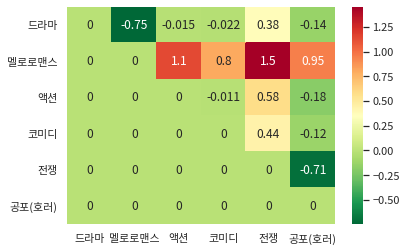

In [45]:
# 시각화

import numpy as np; 
import seaborn as sns; 

np.random.seed(0)

# 한글 지원 폰트
sns.set(font="Noto Sans CJK JP")

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax